# Dog Breeding Identification Project

The purpose of this notebook is to make some analysis over our data.

#### 1. Description of the data

Our data is based on pictures, and the input format for our Perceptron is **(224x224)** Pixels. Almost our data comes in RGB format, that means **3 layers** of (224x224). When reading the pictures is possible to force the resize for this format, so even if there are some pics in a bad format, they will be reshaped to this format.

Por processing, is made a reduction to **grayscale**, so the color information is lost. That is a not so hard problem, as a lot of pictures came in **distorted colors**. Our modern digital cameras opperates in a way that an algorithm tries to correct the **color temperature** of images. And there are no indication, following the image, for what color temperature the sensor was adjusted for.

Perceptrons are trained to deal with **pattern identification**, so the process of image transformation to 1 layer, grayscale, turns our focus more in trying to learn patterns, as vertical lines, or kind of whiskers, or skin/hair texture.

Also we have a **label** column for each picture. So, basically what we are dealing with is **Supervised Learning**.

#### 2. Dealing Dogs and  humans

Basically, we have as input two different datasets:

- the **first** one, for **dogs** - the data is already divided in 3 parts;

  - one for **Training**, where 80% of our data is there;
  
  - one for **Testing**, containing 10% of our data and;
  
  - one for **Validation**, containing 10% of our original data.
  
- the **second** one, for humans - all the data is there, and a method will be later applied for data sepparation.

---

Sources for our research:

- Precision and Recall article at [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)

- 20 Popular Machine Learning Metrics at [Towards Data Science](https://towardsdatascience.com/20-popular-machine-learning-metrics-part-1-classification-regression-evaluation-metrics-1ca3e282a2ce)

- notes from Udacity Data Science Nanodegree classroom

First, import libraries:

In [1]:
import dogbreed as dog
import fnmatch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns

from glob import glob
from matplotlib.cbook import boxplot_stats
from time import time

sns.set_style("whitegrid")
random.seed(8675309)

Using TensorFlow backend.


Evolving a **count files** function:

- first base was taken from [Stack Overflow](https://stackoverflow.com/questions/2632205/how-to-count-the-number-of-files-in-a-directory-using-python):

In [2]:
#########1#########2#########3#########4#########5#########6#########7#########8
def count_files(path):
    '''This function returns the counting for all valid files from a given 
    directory.
    
    Input:
      - path (mandatory) - the full path for our focused directory - 
        (Text String) 
      
    Output:
      - the number of valid files at this directory (Integer)     
    '''
    count = len([1 for x in list(os.scandir(path)) if x.is_file()])
    
    return count

Testing it:

- we already manually counted the valid files at **home** directory

In [3]:
count_files('.')

11

Evolving a `os.walk` function to run over files in directories:

- first base code can be found at [QA Stack](https://qastack.com.br/programming/16953842/using-os-walk-to-recursively-traverse-directories-in-python)

Now, adapting and co-evolving both functions...

I could produce this `count_files` over here:

- first version, can navigate through directories and **print** the counts for valid files at each one;

- later added a `suppress` parameter, just to elliminate noise at the beginning of each string containing info about a speficic directory;

- later added a `dic_fold` object, just to return a **dictionnary** for our counts.

Why a **dictionnary**? Just because it is a **harsh table** and it is a very **neat** structure to deal it, adding that it is very fast to **retrieve information** from it!

In [4]:
#########1#########2#########3#########4#########5#########6#########7#########8
def fn_walk(path,
            suppress=0,
            verbose=False):
    '''
    This function takes a path and makes a count, navigating through
    subdirectories, in search of valid files. This is a good function when you
    have for example, some directories with a bunch of subdirectories, each one
    containing pictures of a specific theme. So, it was designed to opperate over
    a directory tree of 3 deepness levels - first is the base, second is the label
    as subfoldes and the third is the image files.
    
    Inputs:
      - path (mandatory) - the base directory to star your search (Text String)
      - suppress (optional) - the number of initial characters to suppres from
        the keys of the dictionnary (Integer, default=0)
      - verbose (optional) - if you want some verbosity on this function
        (default=False)
        
    Outputs:
      - total - the total number of valid files found in your search (Integer)
      - dic_fold - the subdirectories as keys and the specific countings as 
        Integers
    '''

    total = 0
    dic_fold = {}
    
    if verbose:
        print('###function walk started')
    
    for root, vdir, files in os.walk(path):
        count = count_files(path=root) #calling my function
        
        if count > 0:
            key_fold = root[suppress:]
            if verbose:
                print('{}: {} file(s)'.format(key_fold, count))
            total += count
            dic_fold[key_fold] = count 
        
    return total, dic_fold

Testing it:

In [5]:
path='.'
res, dic_fold = fn_walk(path='.',
                        suppress=2,
                        verbose=True)
print('*found {} files in {}'.format(res, path))

dic_fold

###function walk started
: 11 file(s)
images: 17 file(s)
bottleneck_features: 5 file(s)
haarcascades: 1 file(s)
__pycache__: 2 file(s)
requirements: 8 file(s)
.ipynb_checkpoints: 4 file(s)
saved_models: 5 file(s)
*found 53 files in .


{'': 11,
 'images': 17,
 'bottleneck_features': 5,
 'haarcascades': 1,
 '__pycache__': 2,
 'requirements': 8,
 '.ipynb_checkpoints': 4,
 'saved_models': 5}

---


## Dogs Analysis

The images are in 3 already splitted datasets

- the first one represents 80% of all the pics, and were used for **Train**

- the second, 10% for **Test** and;

- the third one, 10% for **Validation**.

As out Perceptron could see for **Training** only the **first** group, so we will focus our statistics on this group.

Why this other groups exist? Just because when we are in the **Test** or **Validation** phases, we don´t want to show the Perceptron data that was already shown. The idea is not to **contaminate** the later steps.

Walking on the `dog_images/train` directory

In [6]:
path = '../../../data/dog_images/train'
res, key_dog = fn_walk(path=path, 
                       suppress=35,
                       verbose=True)
print('*found {} files in {}'.format(res, path))

###function walk started
Mastiff: 58 file(s)
Doberman_pinscher: 47 file(s)
Curly-coated_retriever: 50 file(s)
Borzoi: 56 file(s)
Bichon_frise: 62 file(s)
Chinese_crested: 50 file(s)
Finnish_spitz: 34 file(s)
Welsh_springer_spaniel: 44 file(s)
Bedlington_terrier: 48 file(s)
Papillon: 63 file(s)
Saint_bernard: 30 file(s)
Australian_terrier: 46 file(s)
Parson_russell_terrier: 30 file(s)
Norfolk_terrier: 46 file(s)
Yorkshire_terrier: 30 file(s)
Boston_terrier: 65 file(s)
Norwegian_buhund: 26 file(s)
Bluetick_coonhound: 35 file(s)
Field_spaniel: 33 file(s)
Tibetan_mastiff: 48 file(s)
Alaskan_malamute: 77 file(s)
Manchester_terrier: 29 file(s)
Boxer: 64 file(s)
Flat-coated_retriever: 63 file(s)
Irish_wolfhound: 53 file(s)
Miniature_schnauzer: 42 file(s)
Boykin_spaniel: 53 file(s)
Greater_swiss_mountain_dog: 46 file(s)
American_foxhound: 50 file(s)
Nova_scotia_duck_tolling_retriever: 54 file(s)
Black_and_tan_coonhound: 37 file(s)
German_shorthaired_pointer: 48 file(s)
English_setter: 53 file(

And what I expect from this data? Something like:

- as we have **6680** pics, in a **fair** distribution, we will have near to **50** pics for each class (each **dog breed**), so the Perceptron will be trained in a more **balanced** way;

- personally I expected a Standard Deviation for items/classes near to **5%**, so in **rough numbers**, kind of **45** dogs at the smallest class and kind of **55** dogs at the largest class.

In [7]:
6680 / 133

50.225563909774436

Here the magic happens... **describe** method!

- we have **133** classes;

- with a mean near to **50** (as expected);

- but... a **high** standard deviation of near to **12** (that is not nice!);

- min of **26** and max of **77** are **not** nice!

*The training of our Perceptron can be affected by showing too much of one breed, and too few of another one...*

In [8]:
df_dogs = pd.DataFrame.from_dict(data=key_dog, 
                                 orient='index', 
                                 columns=['count'])
df_dogs.describe()

,count
count,133.000000
mean,50.225564
std,11.863885
min,26.000000
25%,42.000000
50%,50.000000
75%,61.000000
max,77.000000


We have 77 pics of **Alaska Malamute** and only 26 pics of **Norwegian Buhund**, so:
    
- we have almost **3 times** more pictures from the first breed than the second one;

- the **weakest** group is **24 pics** below our expectation of **50 pics** in mean.

In [9]:
77 / 26

2.9615384615384617

What to say about **Dog Pics** data?

- It is a **high biased** data, as our Perceptron will train **much better** for recognizing an **Alaska Malamute** than a **Norwegian Buhund**!

---

#### Critics about this data

- The main metric that we are using in this project is **Accuracy**;

- and Accuracy is **very sensible** to **imbalanced class distributions**;

There are a lot of critics about using **Accuracy** over **Imbalanced Data**. At Towards Data Science article (refered in the beginning of this paper), clearly it says about **Precision**: (**bold** parts are mine annotations)

*"There are many cases in which classification accuracy is **not a good indicator** of your model performance. One of these scenarios is when your class distribution is **imbalanced** (one class is more frequent than others). In this case, even if you predict all samples as the most frequent class you would get a high accuracy rate, which does not make sense at all (because your model is not learning anything, and is just predicting everything as the top class)"*

For me, it is a good explanation of why to in general, avoid **imbalanced data** for training classes:

- basically you are training a Perceptron to be so speciallized on **Alaska Malamute** doggos. And then, even the teeths, or the whiskers of this big dog breed will be well-understood by our Perceptron artificial neurons;

- it is a kind of the problem to having a **dog kennel** in hour house. And then taking someone to take a look for your precious dogs. And of course, you don´t have all the **dog breeds** in the planet. And this guy will learn everything about some kinds of dogs. But when he moves into another kennel, in another house, he will turn really confused, about **new breeds**, and new ways to grow them, and everything;

- what to do? We could just delete the extra files for taking a **more balanced** dataset. It have a cost, as we will have less pictures to show to our Perceptron. Or we could try other metrics. **Towards Data Science** article says, for in these cases, try **Precision** metrics. So we could start trying other metrics for this data.

---

Plotting some graphs about **dogs dataset**:

- Boxplots from data [here](https://stackoverflow.com/questions/33518472/how-to-get-boxplot-data-for-matplotlib-boxplots)

- using Seaborn [documentation](https://seaborn.pydata.org/generated/seaborn.boxplot.html)

I choose for a first view, **Boxplot**. Why? Just because this Pandas `describe` method gives us a good **number** insights about our data.

But, when you see the box, and the whiskers, things goes much clearer! And a good add for Boxplot normally is **Swarmplot**. So, if plots are kind of **bees**, with a Swarmplot, I can have a visual insight of how the **beehive** is structured:

- for example, if I have kind of a **central aggregation**, and then some kind of **local nucleous**, on one, or both whiskers;

- if the whiskers are so **assymetrical** or not;

- something about our **outliers**.

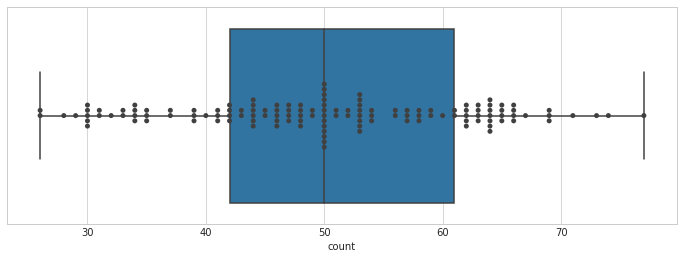

In [10]:
fig_dims = (12, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(x="count", 
            ax=ax, 
            data=df_dogs)
sns.swarmplot(x="count", 
              data=df_dogs, 
              color=".25");

Another fun plotting to use is **Countplot**.

- Seaborn gives us a really **neat** visuallisation;

- It was a good experience to use some kind of structure that is similar to Pandas behavior, just to **plot** graphs.

I can see, for example:
    
- by the countings, what is the **frequency** for each one;

- I can see a lot of countings with exactly **50** pictures inside, and this is really **nice**;

- I can also see a spreading of other countings, going from, let me say, 1-4 countings in a spred, going form **26** through **77** pics on each one - so in a spread of differences of **51**;

- and also, considering **more than 4**, this range compresses not so much, going from **30** through **60** - so in a spread of differences of **30**.

So, to correct these data, it could be suggested to:

1. Take the counts for **50+** and try to not gather more data on these dog breeds;

2. take the counts **lesser than 50** and try to add more pics for these breeds!

*I already know that a perfect balanced dataset is **pratically impossible**! But the worst problem here is not showing **too much** for example, **Alaska Malamute** pics to our Perceptron, but to show **so few** pics form for example, **Norwegian Buhund** breed, so our Perceptron cannot learn about the essential pattern to recognize this kind of dogs!*

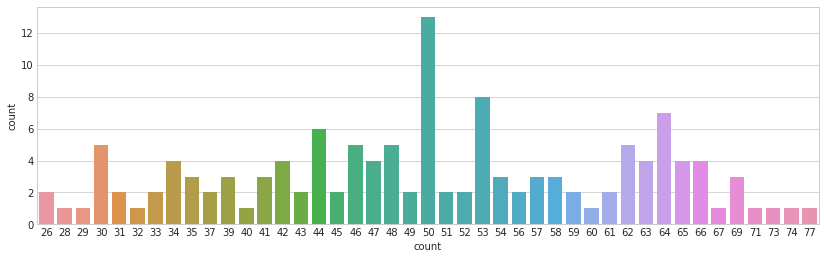

In [11]:
fig_dims = (14, 4)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.countplot(x=df_dogs['count'])

---

## For humans

Now I have a **much larger** dataset, with about 13233 pics, spraded in 5749 individuals:

- I have nothing as a kind of **human breed** in this data. What I have now is distinct human beings;

- what I expect from this data? Roughly **2-3 pictures** from each one of this individuals. 

In [12]:
path_h = '../../../data/lfw'
tot, key_human = fn_walk(path=path_h, 
                         suppress=18,
                         verbose=True)
print('*found {} files in {}'.format(tot, path_h))

###function walk started
Dan_Ackroyd: 1 file(s)
Alex_Corretja: 1 file(s)
Daniele_Bergamin: 1 file(s)
Donald_Carty: 1 file(s)
Barry_Switzer: 1 file(s)
Jeong_Se-hyun: 9 file(s)
Ellen_Engleman: 2 file(s)
Peter_Lundgren: 1 file(s)
Stephen_Thompson: 1 file(s)
Hernan_Crespo: 1 file(s)
Marquier_Montano_Contreras: 1 file(s)
Adriana_Lima: 1 file(s)
Penny_Dupuie: 1 file(s)
Jimmy_Kimmel: 2 file(s)
Michael_Clarke_Duncan: 1 file(s)
Jane_Clayson: 1 file(s)
Paul_Celluci: 1 file(s)
Jorge_Valdano: 2 file(s)
Rodolfo_Abalos: 1 file(s)
Paul_Reiser: 1 file(s)
Phil_Bennett: 1 file(s)
Ibrahim_Jaafari: 2 file(s)
Rafael_Vinoly: 1 file(s)
Stuart_Townsend: 1 file(s)
Miranda_Otto: 1 file(s)
Michael_Kahn: 1 file(s)
Linus_Roache: 1 file(s)
Michael_Guiler: 1 file(s)
Julianne_Moore: 19 file(s)
Jake_Gyllenhaal: 5 file(s)
Satnarine_Sharma: 1 file(s)
Miguel_Angel_Rodriguez: 1 file(s)
Nick_Price: 1 file(s)
Tony_Parker: 2 file(s)
Janusz_Kaminski: 1 file(s)
James_Layug: 1 file(s)
Rohinton_Mistry: 1 file(s)
Mike_Myers: 7 fi

OK, I can se in **Describe**, that:
    
- my **mean** was **2.3**, so, as much as I expected;

- for my **whikers**, I have **1** picture for 25% quartile, and this is not a surprise;

- and for 75% quartile, I took a **2** pictures, what is quite a bit lower than I expected (perhaps I would find there **4** pictures, and not only **2**!);

- and a kind of a **giant outlier** there, with **530** pics!

In [13]:
df_humans = pd.DataFrame.from_dict(data=key_human, 
                                   orient='index', 
                                   columns=['count'])
df_humans.describe()

,count
count,5749.000000
mean,2.301792
std,9.016410
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,530.000000


**High biased data**, as there is a guy there, to be trained **230 times** our average, for his face!

In [14]:
530 / 2.301792

230.2553836315358

Our **Boxplot** turned so **biased** by some outliers, that is quite impossible to take a good view of it:

- why to not just **remove** the outliers, and re-plot the Boxplot? Just because if we do this, we are **lying** about our statistics. As we already **trained** our Percetron in a so **biased** way!

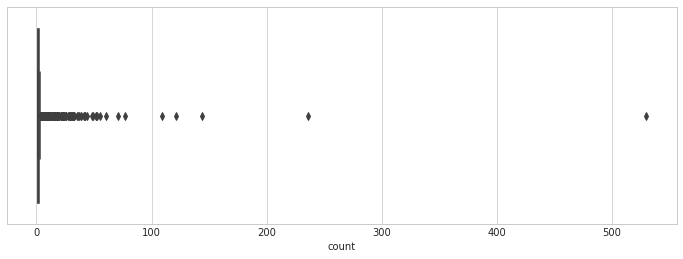

In [15]:
fig_dims = (12, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(x="count", 
            ax=ax, 
            data=df_humans);

Adding **Swarmplot** shows how some **individuals** distorted our data:

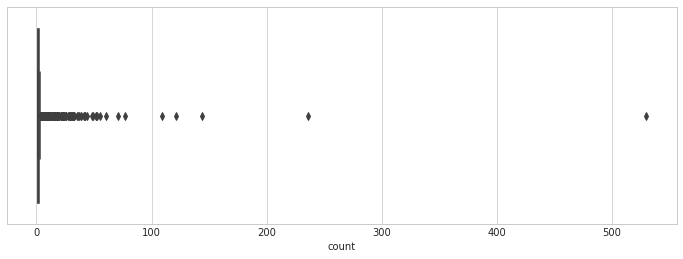

In [16]:
fig_dims = (12, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(x="count", 
            ax=ax, 
            data=df_humans)
#don´t run it, it is so long to process!
#sns.swarmplot(x="count", 
#              data=df_humans, 
#              color=".25");

Another way to see it, is looking at **Countplot**:
    
- we can see **4000+** individuals trained under **1** pic and then;

- kind of **750** individuals traindes under **2** pics;

- decreasing really **fast**, until **5** pics, and then came these outliers.

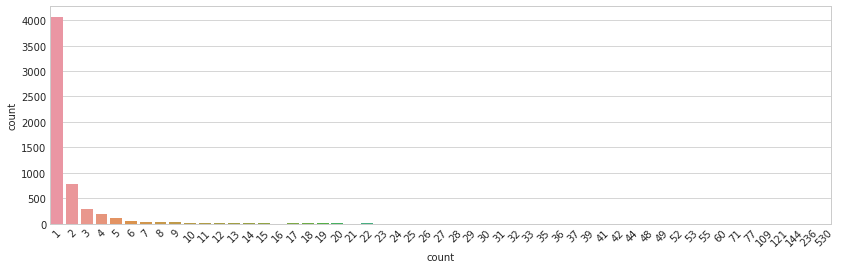

In [17]:
import matplotlib.pylab as plt

fig_dims = (14, 4)
fig, ax = plt.subplots(figsize=fig_dims)
plt.xticks(rotation=45)
ax = sns.countplot(x=df_humans['count'])

About the outliers:
    
- I tried to filter the amount of pics, to get kind of **1%** of the **most-pics outliers**;

- So, with **20+** pics, I could isolate the 57 outliers that appeared there;

- the names of some of the **most notable** outliers are:

  - George W Bush (530)
  
  - Colin Powell (236)
  
  - Tony Blair (144)
  
  - etc..
  
- other **strange names**, that took my attention, let me see:

  - Saddam Hussein (23)
  
  - Arnold Schwarzenegger (42)
  
  - Bill Clinton (only 29!)
  
*So, a comment: if I want to make an **archeological study** about when this data was collected, I can do it, based in the **frequency** of pics of some public faces that were catalogued here!*

In [18]:
print('length:', len(df_humans[df_humans['count']>20]))
df_humans[df_humans['count']>20]

length: 57


,count
Jose_Maria_Aznar,23
Winona_Ryder,24
Serena_Williams,52
Tom_Daschle,25
Arnold_Schwarzenegger,42
Mahmoud_Abbas,29
Ariel_Sharon,77
Laura_Bush,41
Hugo_Chavez,71
Rudolph_Giuliani,26


A **very exclusive** group:

Roughly, people with **more than 20 pictures** in the dataset, are represented by a group of **1% of the total people** in the dataset!

In [19]:
100 * (57 / 5749)

0.9914767785701861

And pictures from them represent as to **22% of the total of pics** in the dataset!

In [20]:
100 * (df_humans[df_humans['count']>20].sum() / 13233)

count    22.088718
dtype: float64

 we see that the dataset is highly imbalanced, with the majority of people having 1 to 9 images. Let's get rid of this majority so that we can better view the rest of the dataset.
 
 Clearly, we have a lot of images from some **specific** people.
 
#### What to say about Human Dataset

1. data is really **Very High** unbalanced;

2. the labels don´t aid us so much, as they don´t add anything special, in terms o information.

Why we don´t just **delete** the extra images from **George W Bush** (the larger outlier), for example?

- because our Perceptron, when a **new** image is shown, learns in the first layers, about **basic patterns**, evolving more and more accurate **filters**;

- so these filters can interpret for example **skin crackes**, our **hair/beard texture**, and passing more and more pics, they tend to be more and more Accurate!

Another thing for us to concern abbout is how professional photographers take pictures from **notorious persons** and form **general people**. The ways that these pictures were taken can **affect** how our Perceptron will learn. So, it tends to, if I show a lot of pictures form notorious persons, not interpret so well normal people. In a extreme situation, common people tends to **not** be recognized as humans by a Perceptron trained too much on pictures from politicians, or famous actors, for example. We don´t dress in the same way, we don´t use so much some accessories, like dark sunglasses, etc..

So the **impact** of unbalanced **dog* and **human** datasets is that this affects negatively our Accuracy for Testing dataset, as it turns our Pereceptron more **biased**.